# Set up workspace

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from scipy.stats import ttest_ind
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
#from eofs.xarray import Eof 

In [2]:
from datetime import timedelta

In [3]:
import cftime
import scipy

In [4]:
import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils')

import make_multisimulation_dataset

In [78]:
from load_ensembles import *
from load_gridcell_areas import *
import quick_map

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [6]:
path_in='/glade/work/czarakas/coupled_PPE/data/data_for_figures/timeseries/'
path_out='/glade/work/czarakas/coupled_PPE/data/data_for_figures/annual_means/'

# Load data

### Define variables to load

In [7]:
var='calculated_PREC_FROM_ATM' #'TS'#'calculated_PREC_FROM_ATM'#'TSKIN'
domain='lnd'
ensemble='coupled'
season='Annual'

In [8]:
end_spinup=40

### Load full ensemble data

In [21]:
var_array_withspinup=xr.open_dataset(path_in+var+'_timeseries_'+ensemble+'.nc')

In [22]:
var_array=var_array_withspinup[var][end_spinup*12:,:,:,:]

### Define function for calculating annual averages based on days per year

In [11]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
    return month_length

In [12]:
if ensemble=='offline':
    ensemble_path='offline_simulations'
    refcase_id='OFFL0000_PI_v02'
elif ensemble=='coupled':
    ensemble_path='coupled_simulations'
    refcase_id='COUP0000_PI_SOM'
if domain=='atm':
    domain_suffix='.cam.h0.'
elif domain=='lnd':
    domain_suffix='.clm2.h0.'
    
basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/'+ensemble_path+'/'+
                                 refcase_id+'/'+domain+'/proc/tseries/'+refcase_id+domain_suffix+'timeseries.'+var+'.nc')

In [13]:
basecase_atm_precc=xr.open_mfdataset('/glade/campaign/cgd/tss/people/czarakas/CoupledPPE/'+ensemble_path+'/'+
                                 refcase_id+'/'+domain+'/proc/tseries/month_1/'+refcase_id+domain_suffix+'PRECC'+'.*.nc',
                                    combine='by_coords')
basecase_atm_precl=xr.open_mfdataset('/glade/campaign/cgd/tss/people/czarakas/CoupledPPE/'+ensemble_path+'/'+
                                 refcase_id+'/'+domain+'/proc/tseries/month_1/'+refcase_id+domain_suffix+'PRECL'+'.*.nc',
                                    combine='by_coords')
basecase_atm_prect = basecase_atm_precc.PRECC+basecase_atm_precl.PRECL
basecase_atm_prect['time']=basecase_atm_prect['time']-timedelta(days=16)
basecase_lnd=basecase_atm_prect.to_dataset(name=var)

OSError: no files to open

In [15]:
"""
ds=basecase_lnd
month_length = xr.DataArray(get_dpm(ds.time.to_index(),
                                      calendar='noleap'),
                              coords=[ds.time], name='month_length')

numyears=np.size(ds.time.groupby('time.year').mean(dim='time').year)

# Calculate the weights by grouping by 'time.season'.
# Conversion to float type ('astype(float)') only necessary for Python 2.x
weights = month_length.groupby('time.year') / month_length.astype(float).groupby('time.year').sum()

# Test that the sum of the weights for each season is 1.0
#weights.groupby('time.month').sum().values
np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(numyears))

# Calculate the weighted average
ds_weighted = (ds[var] * weights).groupby('time.year').sum(dim='time')

"""

"\nds=basecase_lnd\nmonth_length = xr.DataArray(get_dpm(ds.time.to_index(),\n                                      calendar='noleap'),\n                              coords=[ds.time], name='month_length')\n\nnumyears=np.size(ds.time.groupby('time.year').mean(dim='time').year)\n\n# Calculate the weights by grouping by 'time.season'.\n# Conversion to float type ('astype(float)') only necessary for Python 2.x\nweights = month_length.groupby('time.year') / month_length.astype(float).groupby('time.year').sum()\n\n# Test that the sum of the weights for each season is 1.0\n#weights.groupby('time.month').sum().values\nnp.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(numyears))\n\n# Calculate the weighted average\nds_weighted = (ds[var] * weights).groupby('time.year').sum(dim='time')\n\n"

In [16]:
def calculate_annual_timeseries(da, season='Annual',
                               end_spinup=0):
    month_length = xr.DataArray(get_dpm(da.time.to_index(),
                                      calendar='noleap'),
                              coords=[da.time], name='month_length')
    
    numyears=np.size(da.time.groupby('time.year').mean(dim='time'))
    
    if season=='Annual':
        weights = month_length.groupby('time.year') / month_length.astype(float).groupby('time.year').sum()
        
        # Test that the sum of the weights for each year is 1.0
        np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(numyears))
    
        # Calculate the weighted average
        da_weighted = (da * weights).groupby('time.year').sum(dim='time')
        
        this_ensemble_tseries=da_weighted[end_spinup:,:,:]
    else:
        months_filtered = month_length.where(month_length['time.season']==season)
        weights = months_filtered.groupby('time.year') / months_filtered.astype(float).groupby('time.year').sum()
        
        # Test that the sum of the weights for each season is 1.0
        np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(numyears))
        
        da_weighted = (da * weights).groupby('time.year').sum(dim='time')
        this_ensemble_tseries=da_weighted[end_spinup:,:,:]
        
    return this_ensemble_tseries
    

# Do calculations

In [24]:
var_array_annual=calculate_annual_timeseries(var_array,season=season)

In [27]:
params=['frac_sat_soil_dsl_init','d_max', 'fff','sand_pf',
        'upplim_destruct_metamorph', 
        'z0mr', 'zetamaxstable', 'zsno',
        'medlynintercept','kmax','medlynslope',
        'jmaxb0', 'jmaxb1', 'tpu25ratio',
        'maximum_leaf_wetted_fraction',
        'rhosnir',
        'lmrha',
        'nstem',
        ]
param_colors=['skyblue','skyblue', 'skyblue','skyblue',
        '#F8CBAD', 
              'purple', 'purple', 'purple',
        'forestgreen', 'forestgreen', 'forestgreen',
        'lightseagreen', 'lightseagreen','lightseagreen',
              '#6CD2E9',
              'goldenrod',
              'lightgreen',
        'orange',
              ]

ValueError: 'time' not found in array dimensions ('lat', 'lon')

In [63]:
var_array[0,:,:,0].drop_vars(['ensemble_key']).to_dataset(name=var)

<xarray.Dataset>
Dimensions:                   (lat: 96, lon: 144)
Coordinates:
    time                      object 0089-01-16 12:00:00
  * lat                       (lat) float32 -90.0 -88.10526 ... 88.10526 90.0
  * lon                       (lon) float32 0.0 2.5 5.0 ... 352.5 355.0 357.5
Data variables:
    calculated_PREC_FROM_ATM  (lat, lon) float64 ...

In [65]:
ds_grid=var_array[:,:,:,0].drop_vars(['ensemble_key']).to_dataset(name=var)
var_array_ttest=make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=params)
var_array_pval=make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=params)

In [40]:
[tstat, pval] = scipy.stats.ttest_ind(min_tseries, max_tseries, equal_var=False)

In [75]:
for i, param in enumerate(params):
    minkey=crosswalk['Key_short'].values[crosswalk.description==param+', min']
    maxkey=crosswalk['Key_short'].values[crosswalk.description==param+', max']
    min_tseries=var_array_annual[:,:,:,var_array_annual.ensemble_key==minkey].mean(dim='ensemble_key')
    max_tseries=var_array_annual[:,:,:,var_array_annual.ensemble_key==maxkey].mean(dim='ensemble_key')
    
    [tstat, pval] = scipy.stats.ttest_ind(min_tseries, max_tseries, equal_var=False)#, alternative='two-sided')
    var_array_ttest[:,:,i]=tstat
    var_array_pval[:,:,i]=pval

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/glade/u/home/czarakas/.conda/envs/E

In [84]:
pct_sig_change=((var_array_pval<0.05)*landweights2).sum(dim=['lat','lon'])*100

In [92]:
pvals=var_array_pval

pval=pvals[:,:,0]
K = np.sum(~np.isnan(pval).values)
alpha_global=0.05
p_Walker=1-np.power((1-alpha_global),(1/K))

Walker_tests=[]
# Do Walker's test
for i, param in enumerate(params):
    pval=pvals[:,:,i]
    Walker_test=(np.nanmin(pval)<=p_Walker)
    print(Walker_test)
    if Walker_test:
        Walker_tests.append('*')
    else:
        Walker_tests.append('')

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [97]:
pct_sig_change

<xarray.DataArray (ensemble_key: 18)>
array([57.107437, 50.20315 , 57.037777,  8.988339, 19.360193,  7.315507,
       27.86264 , 15.236979, 42.833424, 43.08734 , 49.387814, 41.281315,
       38.869675, 25.945667, 47.985237, 33.337643, 19.476309, 26.383825],
      dtype=float32)
Coordinates:
  * ensemble_key  (ensemble_key) <U28 'frac_sat_soil_dsl_init' ... 'nstem'

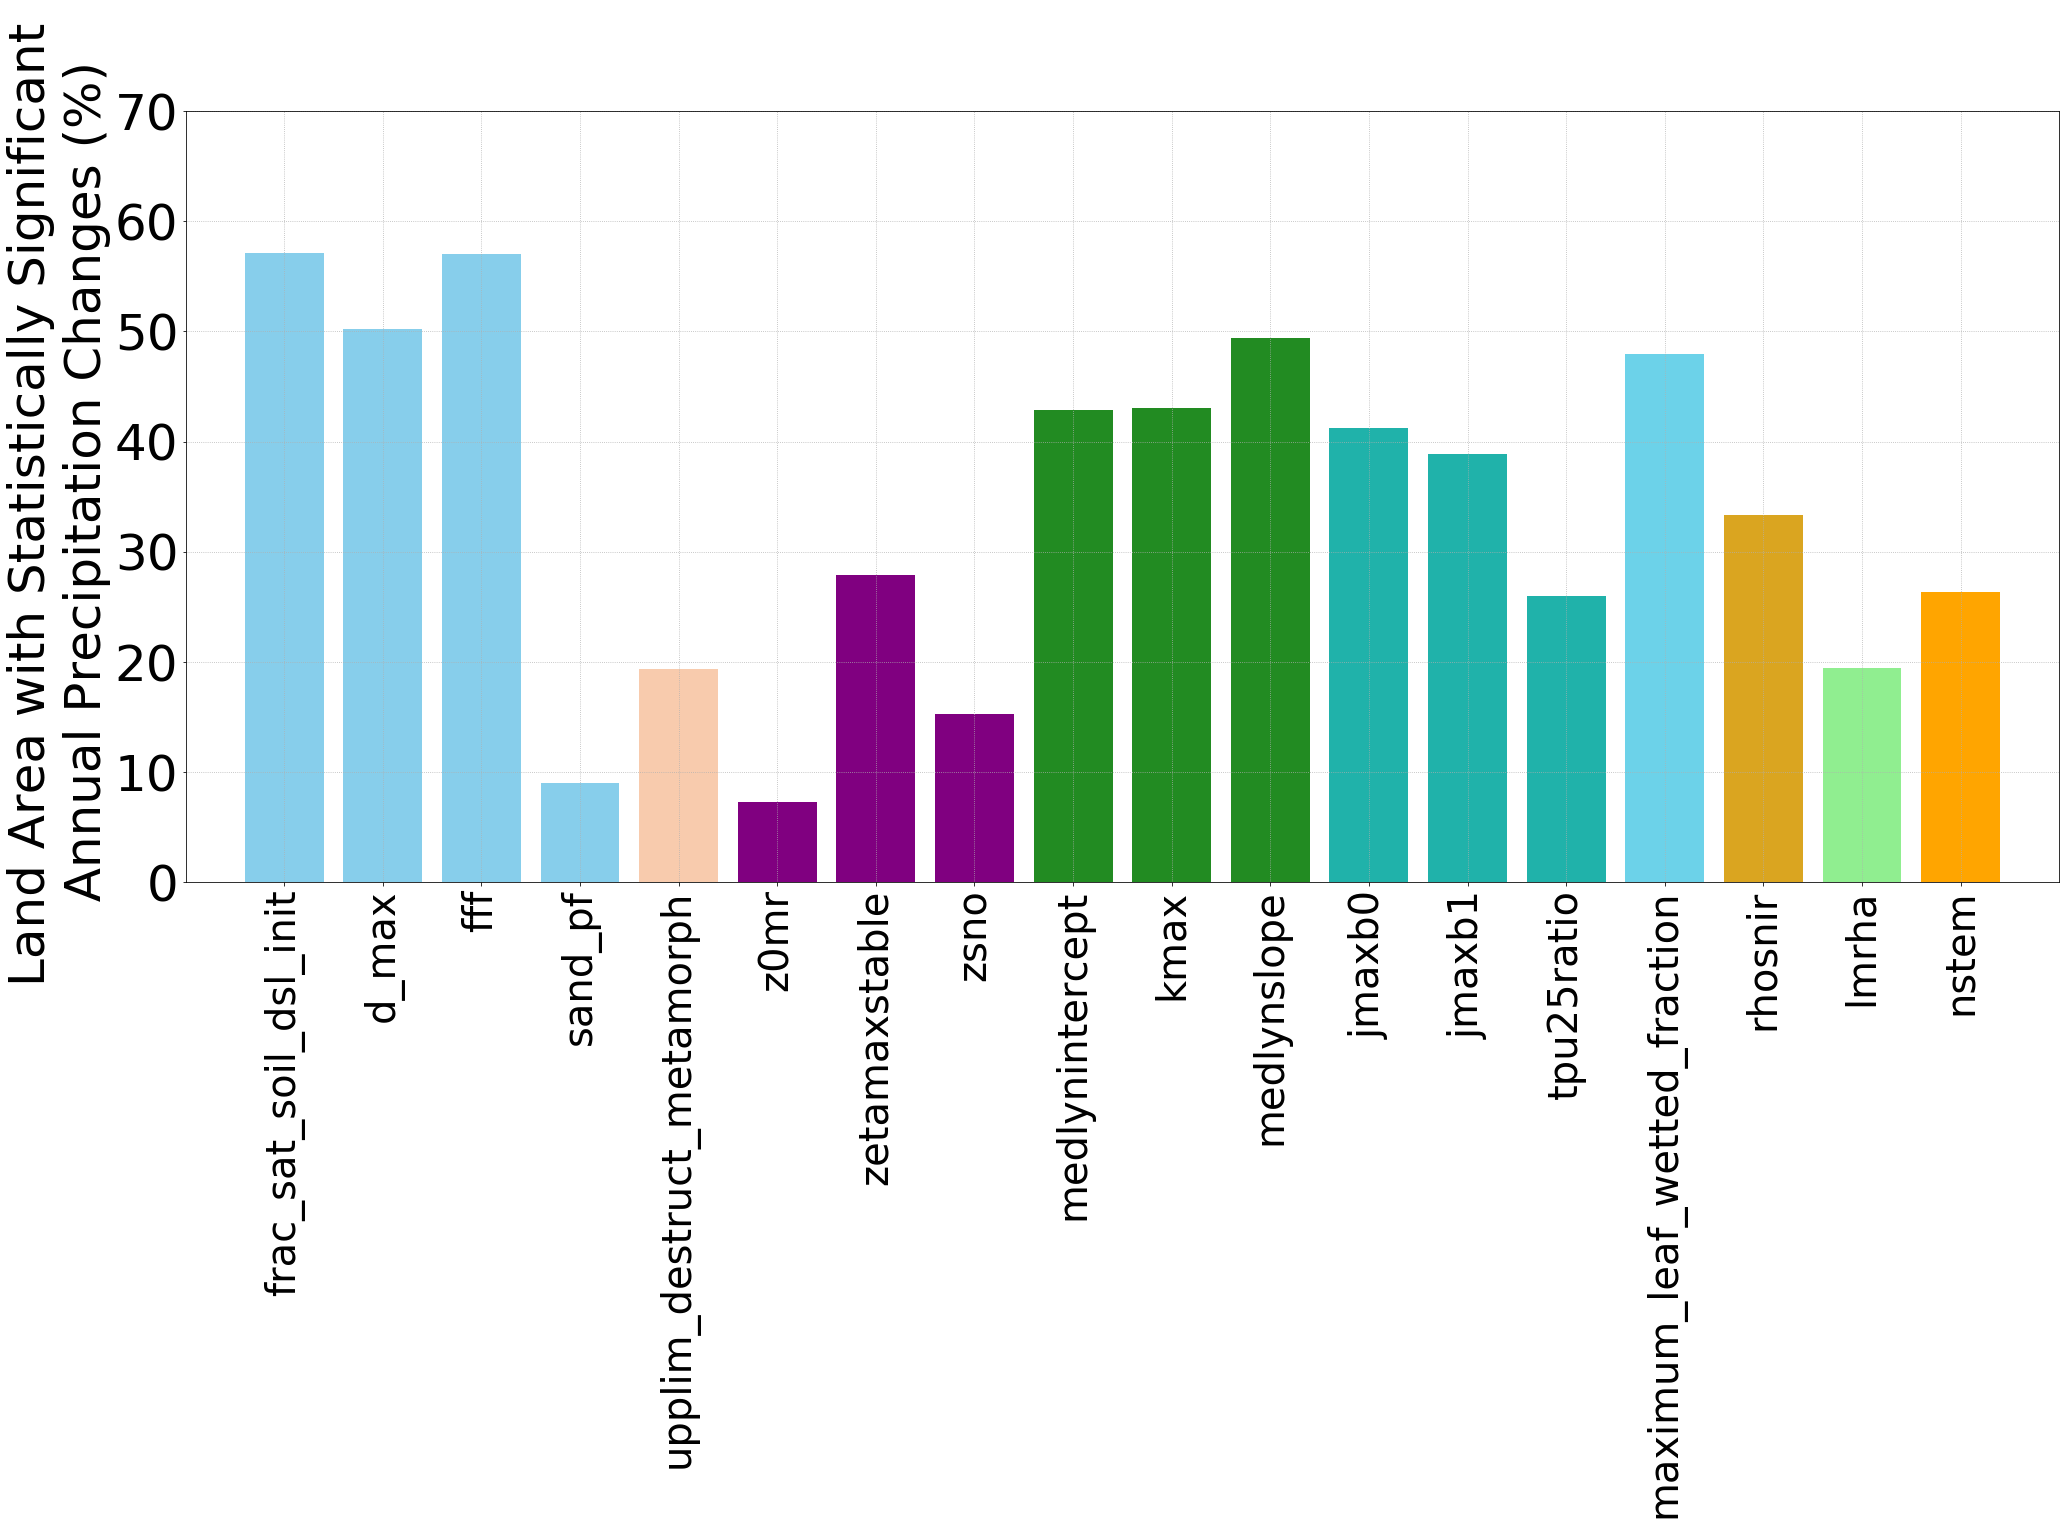

In [103]:
lwidth=6

plt.rcParams.update({'font.size': 50})
plt.figure(figsize=(30,22))
#plt.axhline(y=0,linestyle='--',color='k', linewidth=lwidth)

for i, param in enumerate(params):
    
    plt.bar(i,pct_sig_change[i], color=param_colors[i])

xticks=plt.xticks(np.arange(0, i+1), params, rotation='vertical',fontsize=40)
plt.grid(linestyle=':')
plt.xlim([-1,np.size(params)])
plt.tight_layout()
plt.ylabel('Land Area with Statistically Significant \n  Annual Precipitation Changes (%)',
          fontsize=50)
plt.ylim([0,70])
plt.tight_layout()
plt.savefig('Figures/Figure_S_Precip_Change_Significance_by_Parameter.pdf')

# Calculate where changes are significant

In [21]:
ds_grid = basecase_lnd

var_array_ttest = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)
var_array_pval = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)

In [22]:
for i, key in enumerate(var_array.ensemble_key):
    ds_annual=var_array_annual[:,:,:,i]
    [tstat, pval] = scipy.stats.ttest_ind(var_ref_annual, ds_annual, equal_var=False)#, alternative='two-sided')
    var_array_ttest[:,:,i]=tstat
    var_array_pval[:,:,i]=pval

In [23]:
ds_pval=var_array_pval.to_dataset(name='pval')

fname='pval_'+var+'_'+season+'_mean_'+ensemble+'.nc'
ds_pval.to_netcdf(path_out+fname)